<a href="https://colab.research.google.com/github/taufikdimas/Machine-Learning-2025/blob/main/Crypto_Clustering_%E2%80%94_Kmeans%2CDbscan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KEL5 Crypto Clustering — Kmeans,Dbscan,Orange

ANGGOTA KELOMPOK :

```
27,TAUFIK DIMAS EDYSTARA,2341720062
```

```
19,PETRUS TYANG AGUNG ROSARIO,2341720227
```

```
17,MUHAMMAD ALIF FEBRIANSYAH,2341720025
```

```
23,RAUDHIL FIRDAUS NAUFAL,2341720164
```

```
28,TIONUSA CATUR PAMUNGKAS,2341720093
```


## 1) Libraries

In [1]:
# === Libraries  ===
import warnings, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

import kagglehub
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)
print("Libraries loaded.")

Libraries loaded.


## 2) Load & Tampilkan Data

In [2]:
# === Load & Show Data ===
path = kagglehub.dataset_download("imtkaggleteam/top-100-cryptocurrency-2020-2025")
print("Path to dataset files:", path)

# Baca CSV utama
df = pd.read_csv(f"{path}/top_100_cryptos_with_correct_network.csv")

print("Shape (raw):", df.shape)
display(df.head(200000))

Using Colab cache for faster access to the 'top-100-cryptocurrency-2020-2025' dataset.
Path to dataset files: /kaggle/input/top-100-cryptocurrency-2020-2025
Shape (raw): (211679, 7)


,symbol,date,open,high,low,close,network
0,BTCUSDT,2018-08-01,7735.670,7750.000,7430.000,7604.580,Bitcoin
1,BTCUSDT,2018-08-02,7600.080,7709.460,7455.720,7525.710,Bitcoin
2,BTCUSDT,2018-08-03,7525.710,7540.000,7282.440,7418.780,Bitcoin
3,BTCUSDT,2018-08-04,7412.270,7494.810,6926.000,7009.840,Bitcoin
4,BTCUSDT,2018-08-05,7009.840,7089.870,6882.290,7024.190,Bitcoin
...,...,...,...,...,...,...,...
199995,SUSHIUSDT,2023-02-12,1.312,1.324,1.241,1.267,Ethereum
199996,SUSHIUSDT,2023-02-13,1.267,1.287,1.205,1.284,Ethereum
199997,SUSHIUSDT,2023-02-14,1.283,1.326,1.244,1.308,Ethereum
199998,SUSHIUSDT,2023-02-15,1.308,1.420,1.283,1.418,Ethereum


## 3) Preprocessing
- Normalisasi kolom → lowercase
- Parse `date`
- Cast numerik untuk `open, high, low, close`
- Drop NaN di OHLC
- **Window**: ambil `KEEP_DAYS` terakhir dari tanggal maksimal
- **Per-coin cap**: ambil baris paling akhir per koin hingga `PER_COIN_MAX`
- Scaling + PCA 2D untuk visualisasi

In [3]:
# === Preprocessing + Window & Cap ===
KEEP_DAYS    = 180
PER_COIN_MAX = 500

# Normalisasi kolom & tipe
df.columns = [c.strip().lower() for c in df.columns]
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
else:
    df['date'] = pd.NaT

for c in ['open','high','low','close']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop NaN OHLC & urutkan
df = df.dropna(subset=[c for c in ['open','high','low','close'] if c in df.columns]).copy()
df = df.sort_values(by=[c for c in ['symbol','date'] if c in df.columns], kind='mergesort')

# Window: KEEP_DAYS terakhir
df_s = df.copy()
if 'date' in df_s.columns and not df_s['date'].isna().all():
    max_date = df_s['date'].max()
    min_date = max_date - pd.Timedelta(days=KEEP_DAYS)
    df_s = df_s[df_s['date'] >= min_date].copy()

# Per-coin cap (tail)
if 'symbol' in df_s.columns:
    df_s = (
        df_s.sort_values(['symbol','date'], kind='mergesort')
            .groupby('symbol', group_keys=False)
            .tail(PER_COIN_MAX)
    )

print("Setelah window & cap per coin:", df_s.shape, "| #coins:", df_s['symbol'].nunique())

# Fitur & scaling
Xdf = df_s[['open','high','low','close']].astype(float)
scaler = StandardScaler()
X_all = scaler.fit_transform(Xdf.values)

# PCA (untuk visualisasi nanti)
pca_full = PCA(n_components=2, random_state=42)
Xp_all = pca_full.fit_transform(X_all)

print("Explained variance (PC1+PC2) full:", pca_full.explained_variance_ratio_.sum())

Setelah window & cap per coin: (18100, 7) | #coins: 100
Explained variance (PC1+PC2) full: 0.9999476509367337


## 4)  Sampling per Coin


In [4]:
# === Sampling per Coin ===
RNG = np.random.default_rng(42)
SAMPLE_MODE = 'random'

# Ukuran per koin
N_PER_COIN_KMEANS = 200
N_PER_COIN_DBSCAN = 200
N_PER_COIN_PLOT   = 250

def balanced_per_coin(df_in, n_per_coin, mode='random', rng=None):
    if rng is None:
        rng = np.random.default_rng(42)
    parts = []
    if 'symbol' not in df_in.columns:
        return df_in.iloc[0:0].copy()
    for sym, sub in df_in.groupby('symbol', sort=False):
        if mode == 'recent':
            pick = sub.tail(n_per_coin)
        else:
            if len(sub) <= n_per_coin:
                pick = sub
            else:
                pick = sub.sample(n=n_per_coin, random_state=rng.integers(0, 1_000_000))
        parts.append(pick)
    out = pd.concat(parts, axis=0)
    return out.sort_values(['symbol','date'], kind='mergesort')

# mapping index -> posisi di X_all
pos_map = pd.Series(np.arange(X_all.shape[0]), index=df_s.index)

# subset balanced
df_km = balanced_per_coin(df_s, N_PER_COIN_KMEANS, mode=SAMPLE_MODE, rng=RNG)
df_db = balanced_per_coin(df_s, N_PER_COIN_DBSCAN, mode=SAMPLE_MODE, rng=RNG)
df_pl = balanced_per_coin(df_s, N_PER_COIN_PLOT,   mode=SAMPLE_MODE, rng=RNG)

idx_km = pos_map.loc[df_km.index].to_numpy()
idx_db = pos_map.loc[df_db.index].to_numpy()
idx_pl = pos_map.loc[df_pl.index].to_numpy()

X_km = X_all[idx_km]
X_db = X_all[idx_db]
Xp_pl = Xp_all[idx_pl]

print("Ukuran subset — KMeans:", X_km.shape, "| DBSCAN:", X_db.shape, "| Plot:", Xp_pl.shape)
print("Coins terwakili — KMeans:", df_km['symbol'].nunique(), "| DBSCAN:", df_db['symbol'].nunique(), "| Plot:", df_pl['symbol'].nunique())

Ukuran subset — KMeans: (18100, 4) | DBSCAN: (18100, 4) | Plot: (18100, 2)
Coins terwakili — KMeans: 100 | DBSCAN: 100 | Plot: 100


## 5) KMeans

BEST k = 2 | Silhouette = 0.9958


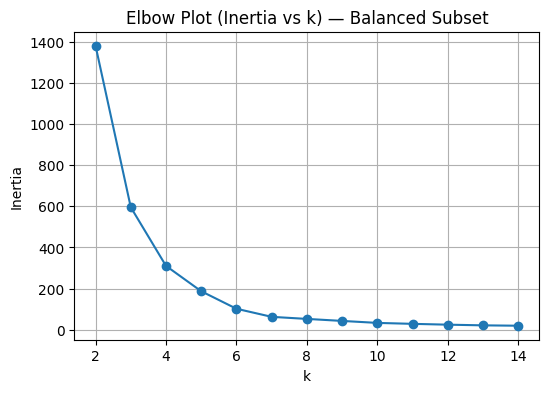

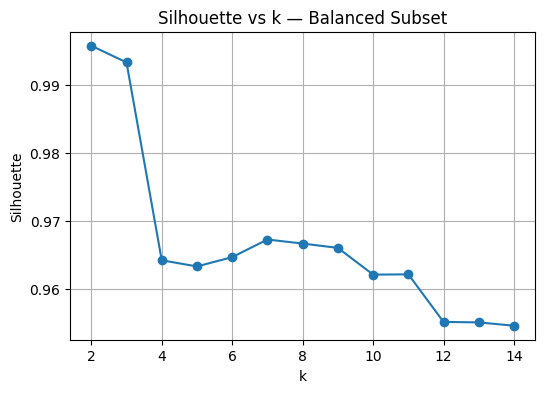

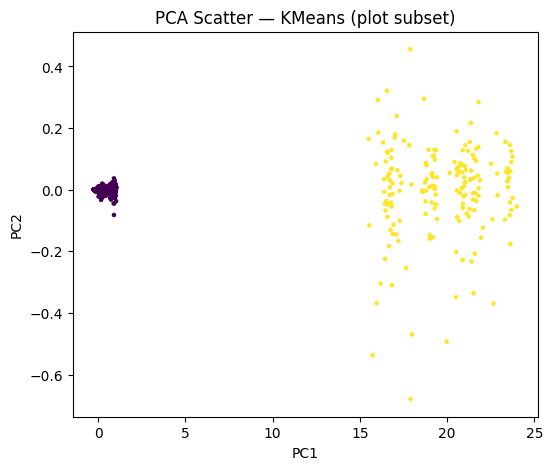

In [10]:
# === KMeans (balanced subset) ===
K_RANGE = range(2, 15)  # 2..14

best_k, best_sil = None, -1
sil_per_k, inertia_per_k = [], []

for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_km)
    sil = silhouette_score(X_km, labels) if len(set(labels)) > 1 else -1
    sil_per_k.append((k, sil))
    inertia_per_k.append((k, km.inertia_))
    if sil > best_sil:
        best_sil, best_k = sil, k

print(f"BEST k = {best_k} | Silhouette = {best_sil:.4f}")

# Fit final dengan best_k
km = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(X_km)
df_km = df_km.copy()
df_km['kmeans_label'] = km.labels_

# Elbow & Silhouette plots
plt.figure(figsize=(6,4))
plt.plot([k for k,_ in inertia_per_k], [v for _,v in inertia_per_k], marker='o')
plt.title("Elbow Plot (Inertia vs k) — Balanced Subset")
plt.xlabel("k"); plt.ylabel("Inertia"); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot([k for k,_ in sil_per_k], [v for _,v in sil_per_k], marker='o')
plt.title("Silhouette vs k — Balanced Subset")
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.grid(True); plt.show()

plt.figure(figsize=(6,5))
plt.scatter(Xp_pl[:,0], Xp_pl[:,1], s=5, c=df_km['kmeans_label'].values)
plt.title("PCA Scatter — KMeans (plot subset)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.show()

## 6) DBSCAN (simplified)

Best DBSCAN → eps: 0.0030159536059728874 min_samples: 8 sil: 0.9559795133545244 noise: 0.04640883977900553


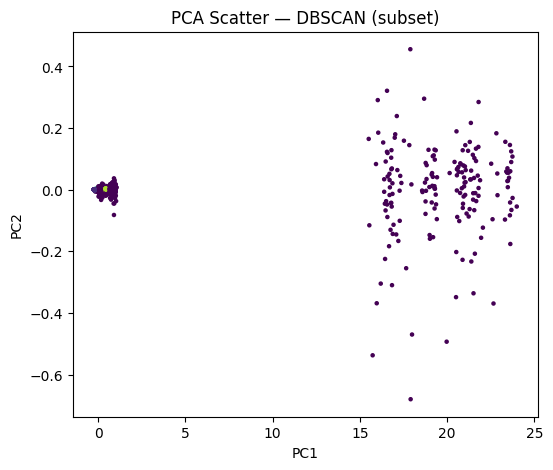

In [9]:
# === DBSCAN (simple, subset only) ===
min_samples = max(4, 2 * X_db.shape[1])

nn = NearestNeighbors(n_neighbors=min_samples).fit(X_db)
dists, _ = nn.kneighbors(X_db)
k_dists = np.sort(dists[:, -1])
eps = float(np.percentile(k_dists, 95))

db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_db)
labels_db = db.labels_

# Silhouette hanya untuk non-noise bila cluster >= 2
mask_core = labels_db != -1
if mask_core.sum() > 1 and len(np.unique(labels_db[mask_core])) > 1:
    sil = float(silhouette_score(X_db[mask_core], labels_db[mask_core]))
else:
    sil = float("nan")

noise_ratio = float((labels_db == -1).mean())

print(f"Best DBSCAN → eps: {eps} min_samples: {min_samples} sil: {sil} noise: {noise_ratio}")

# (Opsional) PCA plot untuk subset DBSCAN
plt.figure(figsize=(6,5))
plt.scatter(Xp_pl[:,0], Xp_pl[:,1], s=5, c=labels_db if len(labels_db)==len(Xp_pl) else None)
plt.title('PCA Scatter — DBSCAN (subset)')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()

## 7)  Export untuk Orange — subset + label

In [7]:
# === Export untuk Orange  ===
try:
    out_km = df_km[['symbol','date','open','high','low','close','kmeans_label']].copy()
except KeyError:
    out_km = df_km.assign(kmeans_label=np.nan)[['symbol','date','open','high','low','close','kmeans_label']]
out_db = df_db[['symbol','date','open','high','low','close']].copy()
out_db = out_db.assign(dbscan_label=labels_db)

out = out_km.merge(out_db, how='outer', on=['symbol','date','open','high','low','close'])
out_csv = "crypto_ohlc_clusters_final_subset.csv"
out.to_csv(out_csv, index=False)
print("Saved:", out_csv)

Saved: crypto_ohlc_clusters_final_subset.csv


## Analisa Hasil Clustering
Berdasarkan proses clustering menggunakan KMeans dan DBSCAN:

**KMeans:**
- K terbaik yang ditemukan berdasarkan silhouette score adalah **k = 2** dengan silhouette score **0.9958**.
- Plot Elbow menunjukkan penurunan inertia yang signifikan pada k=2.
- Plot Silhouette juga mendukung k=2 sebagai jumlah cluster yang optimal.
- Scatter plot PCA dengan label KMeans menunjukkan bahwa data dibagi menjadi 2 cluster yang cukup terpisah.

**DBSCAN:**
- Parameter yang digunakan adalah `eps: 0.0030` dan `min_samples: 8`.
- Silhouette score untuk DBSCAN (tidak termasuk noise) adalah **0.9560**.
- Rasio noise (data yang tidak termasuk dalam cluster) adalah sekitar **4.64%**.
- Scatter plot PCA dengan label DBSCAN menunjukkan pembentukan cluster dan beberapa titik noise.

Secara keseluruhan, kedua metode clustering menghasilkan hasil yang mirip dengan jumlah cluster yang sedikit. KMeans mengidentifikasi 2 cluster utama, sementara DBSCAN juga menemukan cluster yang serupa dengan beberapa titik data yang dianggap sebagai noise. Silhouette scores yang tinggi untuk kedua metode menunjukkan bahwa cluster yang terbentuk cukup terpisah dan padat.